# What is this about?

- The project aims at quantitatively analyze data from two reddit dataset that were collected (by others) through the reddit API using the PRAW python library.
  - The first dataset is regarding the */r/wallstreetbets* subreddit that can be accessed [here](https://www.kaggle.com/datasets/leukipp/reddit-finance-data). The dataset was last updated on 2021/08/16, meaning that we do not have data after 2021/08/16, which explains the discrepancy of posts’ scores, comments numbers if we look at them today.
  - The second dataset is regarding another subreddit, here the [*/r/options*](https://www.kaggle.com/datasets/paolodelia/finance-subreddits/?select=options_subreddit.csv) one. The goal is to compare the two subreddit on the level of engagement and communinity building.
- The project also aims at extracting relevant data from the dataset in order to then coduct qualitative analysis on different threads and posts.

In [ ]:
# import libraries
import pandas as pd
from datetime import datetime
import os
import pickle

In [2]:
# Accessing the files
wsb = pd.read_csv('/data/submissions_reddit.csv')
options = pd.read_csv('/data/options_subreddit.csv', delimiter=";")
whole_wsb = pd.DataFrame(wsb)
whole_opt = pd.DataFrame(options)

# Clearing Data

## Clearing the data for WSB dataframe

In [3]:
whole_wsb['created'] = pd.to_datetime(whole_wsb['created'])

## Clearing the data for OPT dataframe

In [4]:
# Changing column names and order so they match WSB's one

whole_opt.rename(columns={'created_utc': 'created'}, inplace=True) ## renaming the columns that needed to be
#cols = list(whole_wsb_df.columns.values) ## used to get the list of the columns to make sure I match the names
whole_opt['created'] = pd.to_datetime(whole_opt['created'], unit="s")

if 'Unnamed: 0' in whole_opt.columns:
  whole_opt = whole_opt.drop('Unnamed: 0', axis=1) ## removing unmaed column from dataframe

## 1 Month Main Time Frame

In [5]:
# identify the main timeframe
start_date = pd.to_datetime("2021-01-01 00:00:00")
end_date = pd.to_datetime("2021-02-01 23:59:59")

# create dataframe for the specific timeframe
wsb_df = whole_wsb[(whole_wsb["created"] >= start_date) & (whole_wsb["created"] <= end_date)]
opt_df = whole_opt[(whole_opt["created"] >= start_date) & (whole_opt["created"] <= end_date)]

# Numeric Analysis

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
from matplotlib import style
import matplotlib.dates as mdates

sns.set(style='darkgrid', palette='deep')  # 'darkgrid' style with a deep color palette
sns.set_theme(context='notebook', style='dark')
sns.set_style('darkgrid', {'axes.facecolor': 'lightgrey', 'figure.facecolor': 'white', 'grid.color': 'white', 'axes.linewidth': 0})

## Posts Frequency

In [7]:
test = wsb_df['created'].dt.date
posts_per_day = test.value_counts().sort_index()

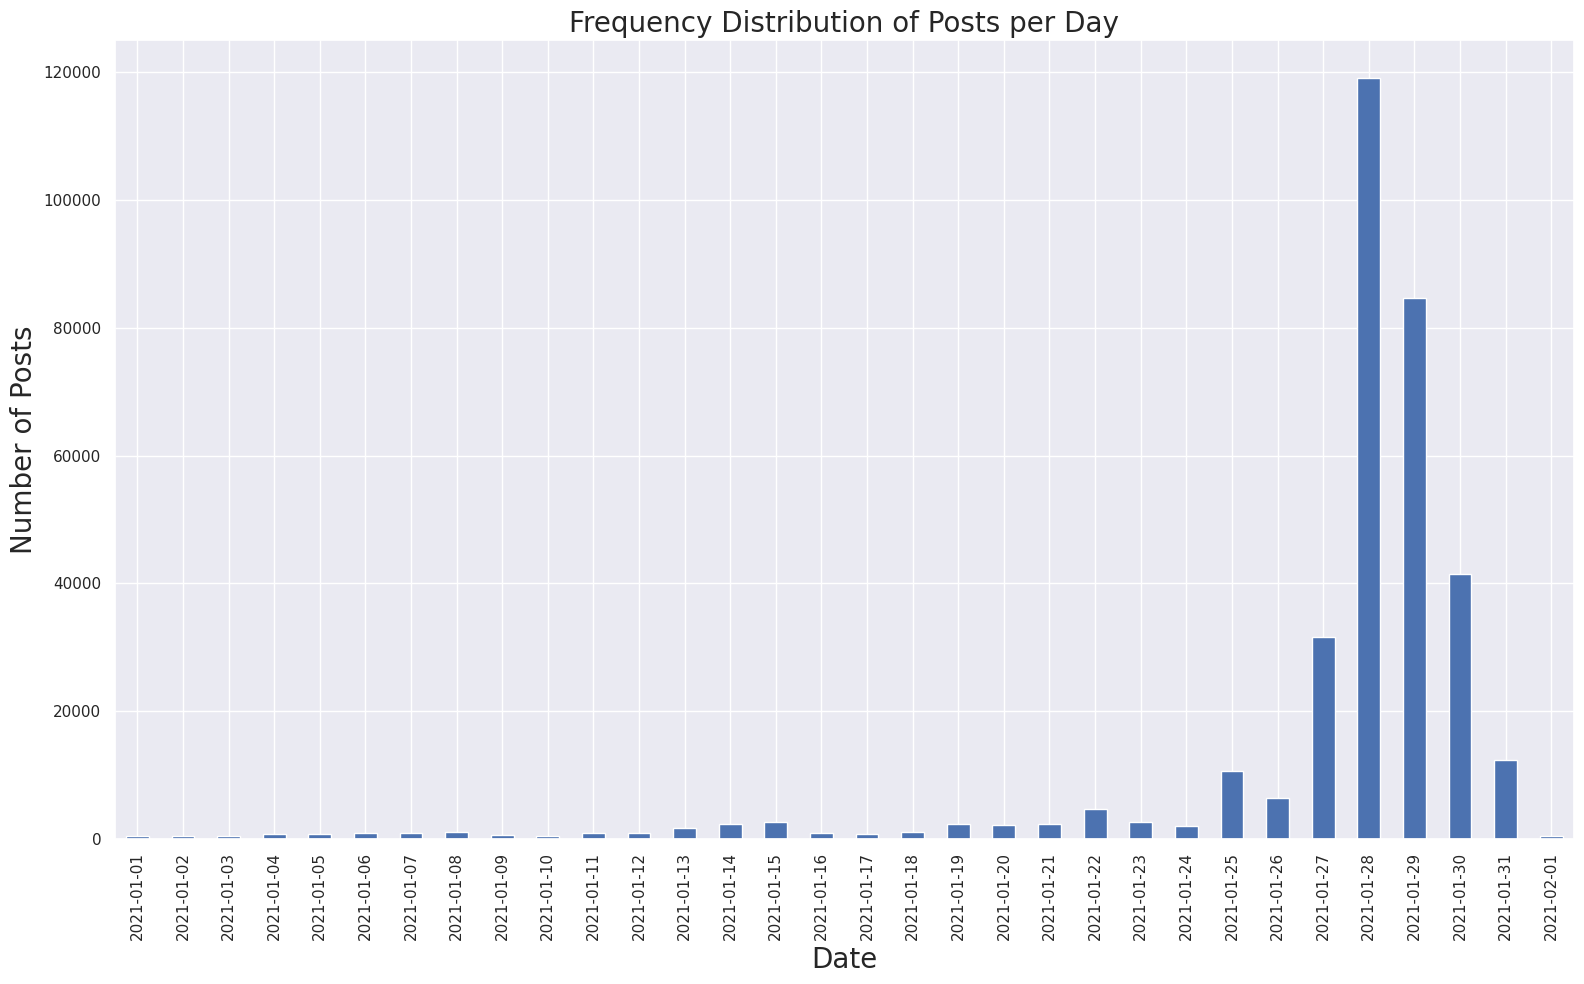

In [49]:
plt.figure(figsize=(16, 10))
posts_per_day.plot(kind='bar')
plt.title('Frequency Distribution of Posts per Day', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Number of Posts', fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.savefig('Frequency Distribution of Posts per Day.pdf')
plt.show()

## Evolution of Post Interactions

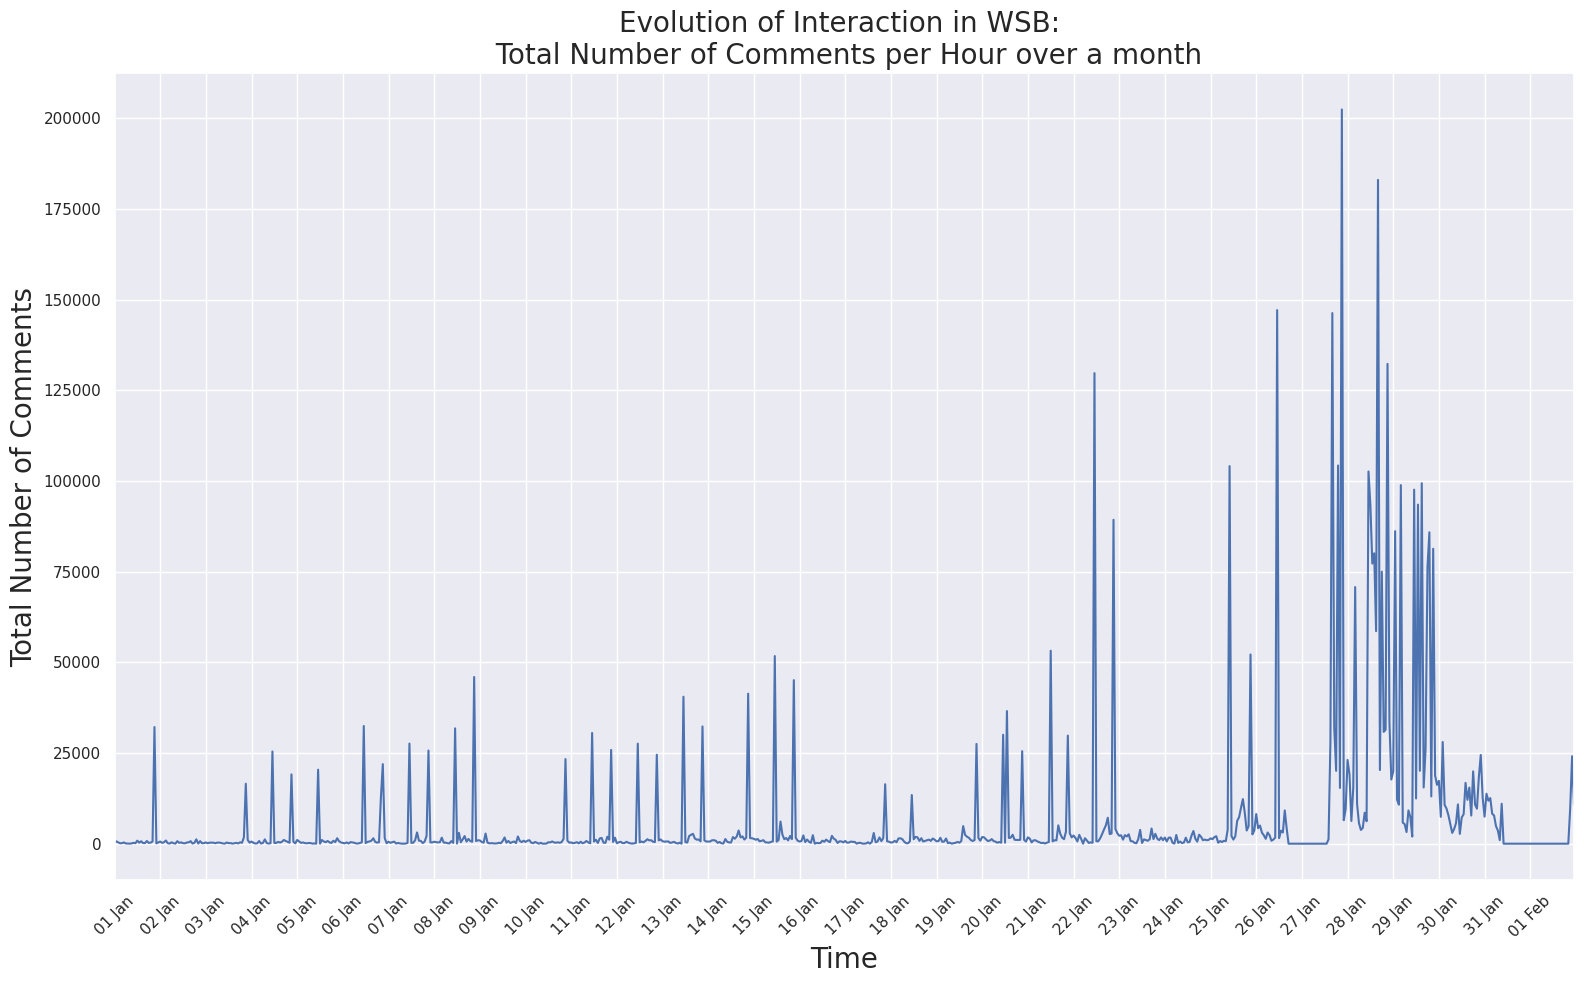

In [9]:
# @title Evolution for WSB
wsb_interaction = wsb_df[['created', 'num_comments']]

# Aggregate comments per day
wsb_comments_per_day = wsb_interaction.groupby(pd.Grouper(key='created', freq='H'))['num_comments'].sum().reset_index() # set frequency of groupings

### Plotting
plt.figure(figsize=(16, 10))
plt.plot(wsb_comments_per_day['created'], wsb_comments_per_day['num_comments'])
plt.title('Evolution of Interaction in WSB: \n Total Number of Comments per Hour over a month', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Total Number of Comments', fontsize=20)
plt.grid(True)


# Format x-axis labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Set major ticks at months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().tick_params(axis='x', rotation=45)  # Rotate x-axis labels by 45 degrees for example
plt.xlim(wsb_comments_per_day['created'].min(), wsb_comments_per_day['created'].max())

#plt.xticks(rotation=50)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig('Evolution of Interaction in WSB.pdf')
plt.show()

In [10]:
# @title Evolution for WSB During GME

# Setting new time frame
start_date_gme = pd.to_datetime("2021-01-24 00:00:00")
end_date_gme = pd.to_datetime("2021-02-01 23:59:59")

# create dataframe for the specific timeframe
gme_interaction = wsb_df[(wsb_df["created"] >= start_date_gme) & (wsb_df["created"] <= end_date_gme)]

#gme_interaction = wsb_df[['created', 'num_comments']]


# Aggregate comments per day
gme_comments_per_day = gme_interaction.groupby(pd.Grouper(key='created', freq='H'))['num_comments'].sum().reset_index() # set frequency of groupings
#gme_comments_per_day = gme_interaction.groupby(gme_interaction['created'])['num_comments'].sum()

### Plotting
plt.figure(figsize=(16, 10))
sns.lineplot(x='created', y='num_comments', data=gme_comments_per_day)
#plt.plot(gme_comments_per_day.index, gme_comments_per_day.values)
plt.title('Evolution of Interaction in WSB During GME: \n Total Number of Comments per Hour', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Total Number of Comments', fontsize=20)
plt.grid(True)

# Format x-axis labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Set major ticks at days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Display day number

# Set minor ticks at 6-hour intervals (adjust for your specific intervals)
#plt.gca().xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%I%p'))  # Display time intervals


#plt.xticks(rotation=50)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig('Evolution of Interaction in WSB during GME.pdf')
plt.show()

## Elites Influence

In order to determine the influence of the elites, we first sort the posts that have the most number of comments or best score, and identify their authors. We then trace when these authors posts and compare it to the evolution of interactions to have a quantitative view of what is happening. At the same time, we look at those post qualitatvely and the comments under them to see what is going on.

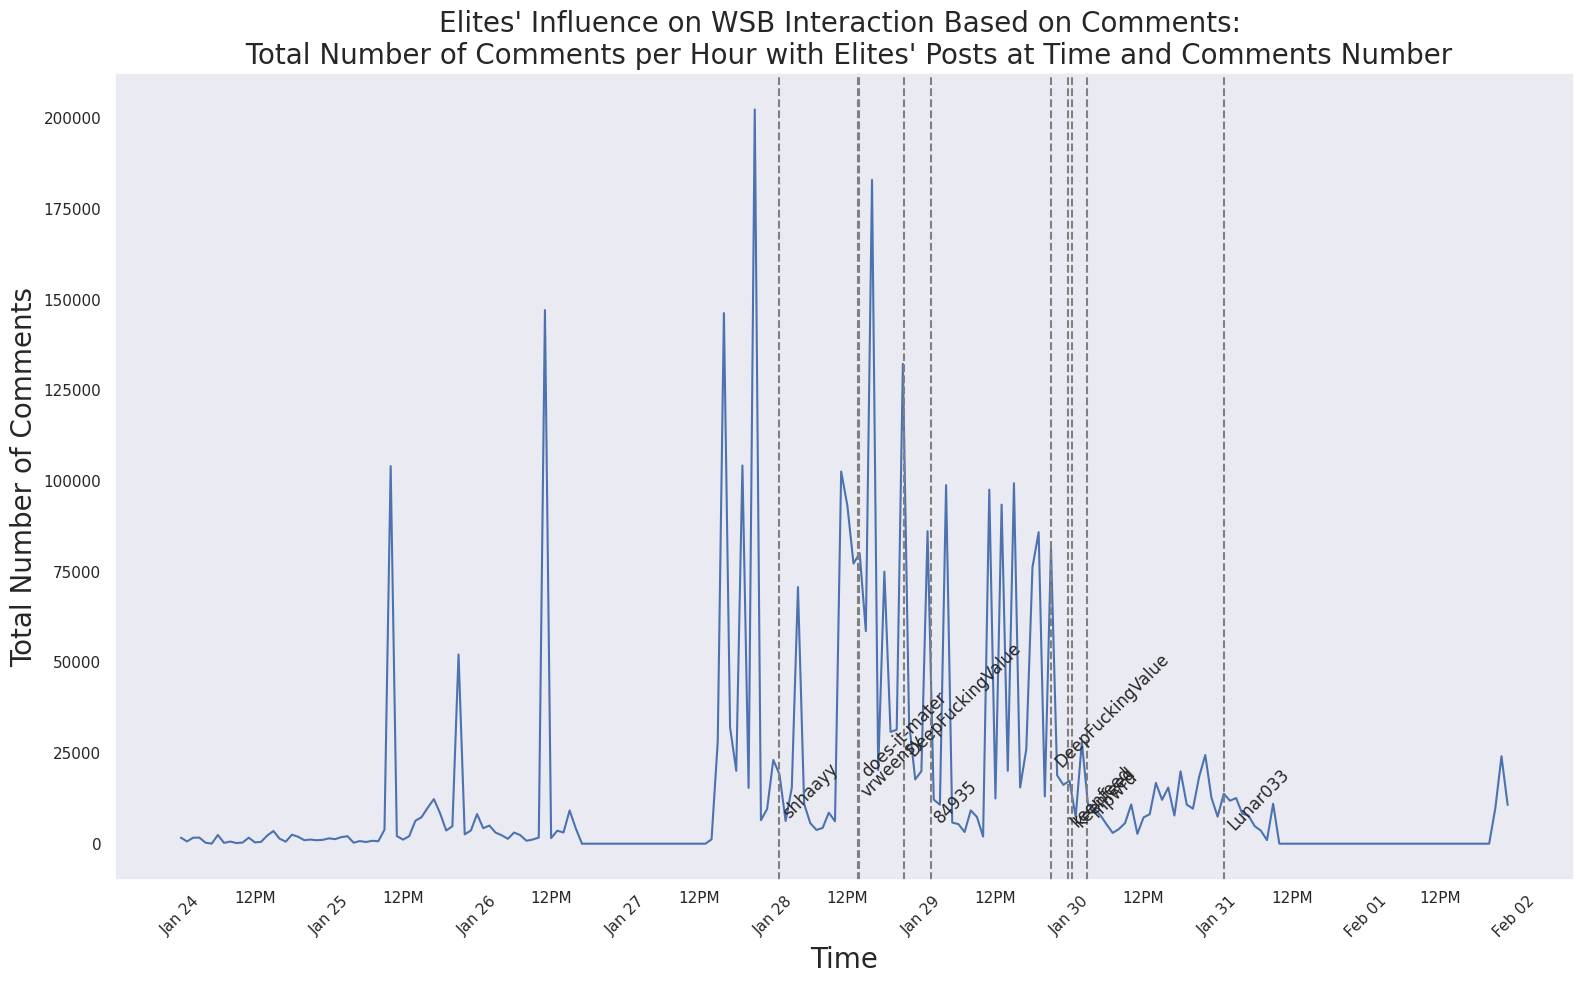

In [11]:
# @title Identify by score and comments number during GME

# Setting new time frame
start_date_gme = pd.to_datetime("2021-01-24 00:00:00")
end_date_gme = pd.to_datetime("2021-02-01 23:59:59")

# create dataframe for the specific timeframe
gme_interaction = wsb_df[(wsb_df["created"] >= start_date_gme) & (wsb_df["created"] <= end_date_gme)]

# Aggregate comments per day
gme_comments_per_day = gme_interaction.groupby(pd.Grouper(key='created', freq='H'))['num_comments'].sum().reset_index() # set frequency of groupings

### Plotting
plt.figure(figsize=(16, 10))

sns.lineplot(x='created', y='num_comments', data=gme_comments_per_day)
plt.title("Elites' Influence on WSB Interaction Based on Comments: \n Total Number of Comments per Hour with Elites' Posts at Time and Comments Number", fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Total Number of Comments', fontsize=20)

# identify by score
gme_sorted_score = gme_interaction[gme_interaction['author'] != 'AutoModerator'].nlargest(10, 'score')
plt.xticks(rotation=45)

for index, row in gme_sorted_score.iterrows():
    plt.axvline(row['created'], color='gray', linestyle='--', alpha=1)
    plt.text(row['created'], row['num_comments'], row['author'], rotation=45, ha='left')

# Format x-axis labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator())  # Set major ticks at days
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Display day number

# Set minor ticks at 6-hour intervals (adjust for your specific intervals)
plt.gca().xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter('%I%p'))  # Display time intervals


#plt.xticks(rotation=50)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig("Elites' Influence on WSB Interaction Based on Comments Number.pdf")
plt.show()

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Assuming wsb_df is your DataFrame with necessary columns including 'created', 'num_comments', and 'score'

# Your code for setting up the timeframe and aggregating comments per hour remains the same

# Creating the plot with a secondary y-axis for 'score'
fig, ax1 = plt.subplots(figsize=(16, 10))

# Plotting the total number of comments per hour on the left y-axis
sns.lineplot(x='created', y='num_comments', data=gme_comments_per_day, ax=ax1)
ax1.set_title("Elites' Influence on WSB Interaction Based on Score: \n Total Number of Comments per Hour Between Jan 24 and Feb 1 with Elites' Posts at Time and Score", fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
ax1.set_ylabel('Total Number of Comments', fontsize=20)

# Identifying elites' posts by score and setting their scores on the right y-axis
gme_sorted_score = gme_interaction[gme_interaction['author'] != 'AutoModerator'].nlargest(10, 'score')

# Plotting scores on the right y-axis for the top posts
ax2 = ax1.twinx()
ax2.set_ylabel('Score', fontsize=20, weight='bold')

for index, row in gme_sorted_score.iterrows():
    ax1.axvline(row['created'], color='gray', linestyle='--', alpha=1)
    ax2.text(row['created'], row['score'], row['author'], ha='left', fontsize=15, weight='bold')
    ax2.scatter(row['created'], row['score'], color='red', s=0)  # Plotting score on right y-axis

# Formatting x-axis labels
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax1.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 12)))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%I%p'))

plt.tight_layout()
plt.savefig("Elites' Influence on WSB Interaction Based on Score.pdf")
plt.show()


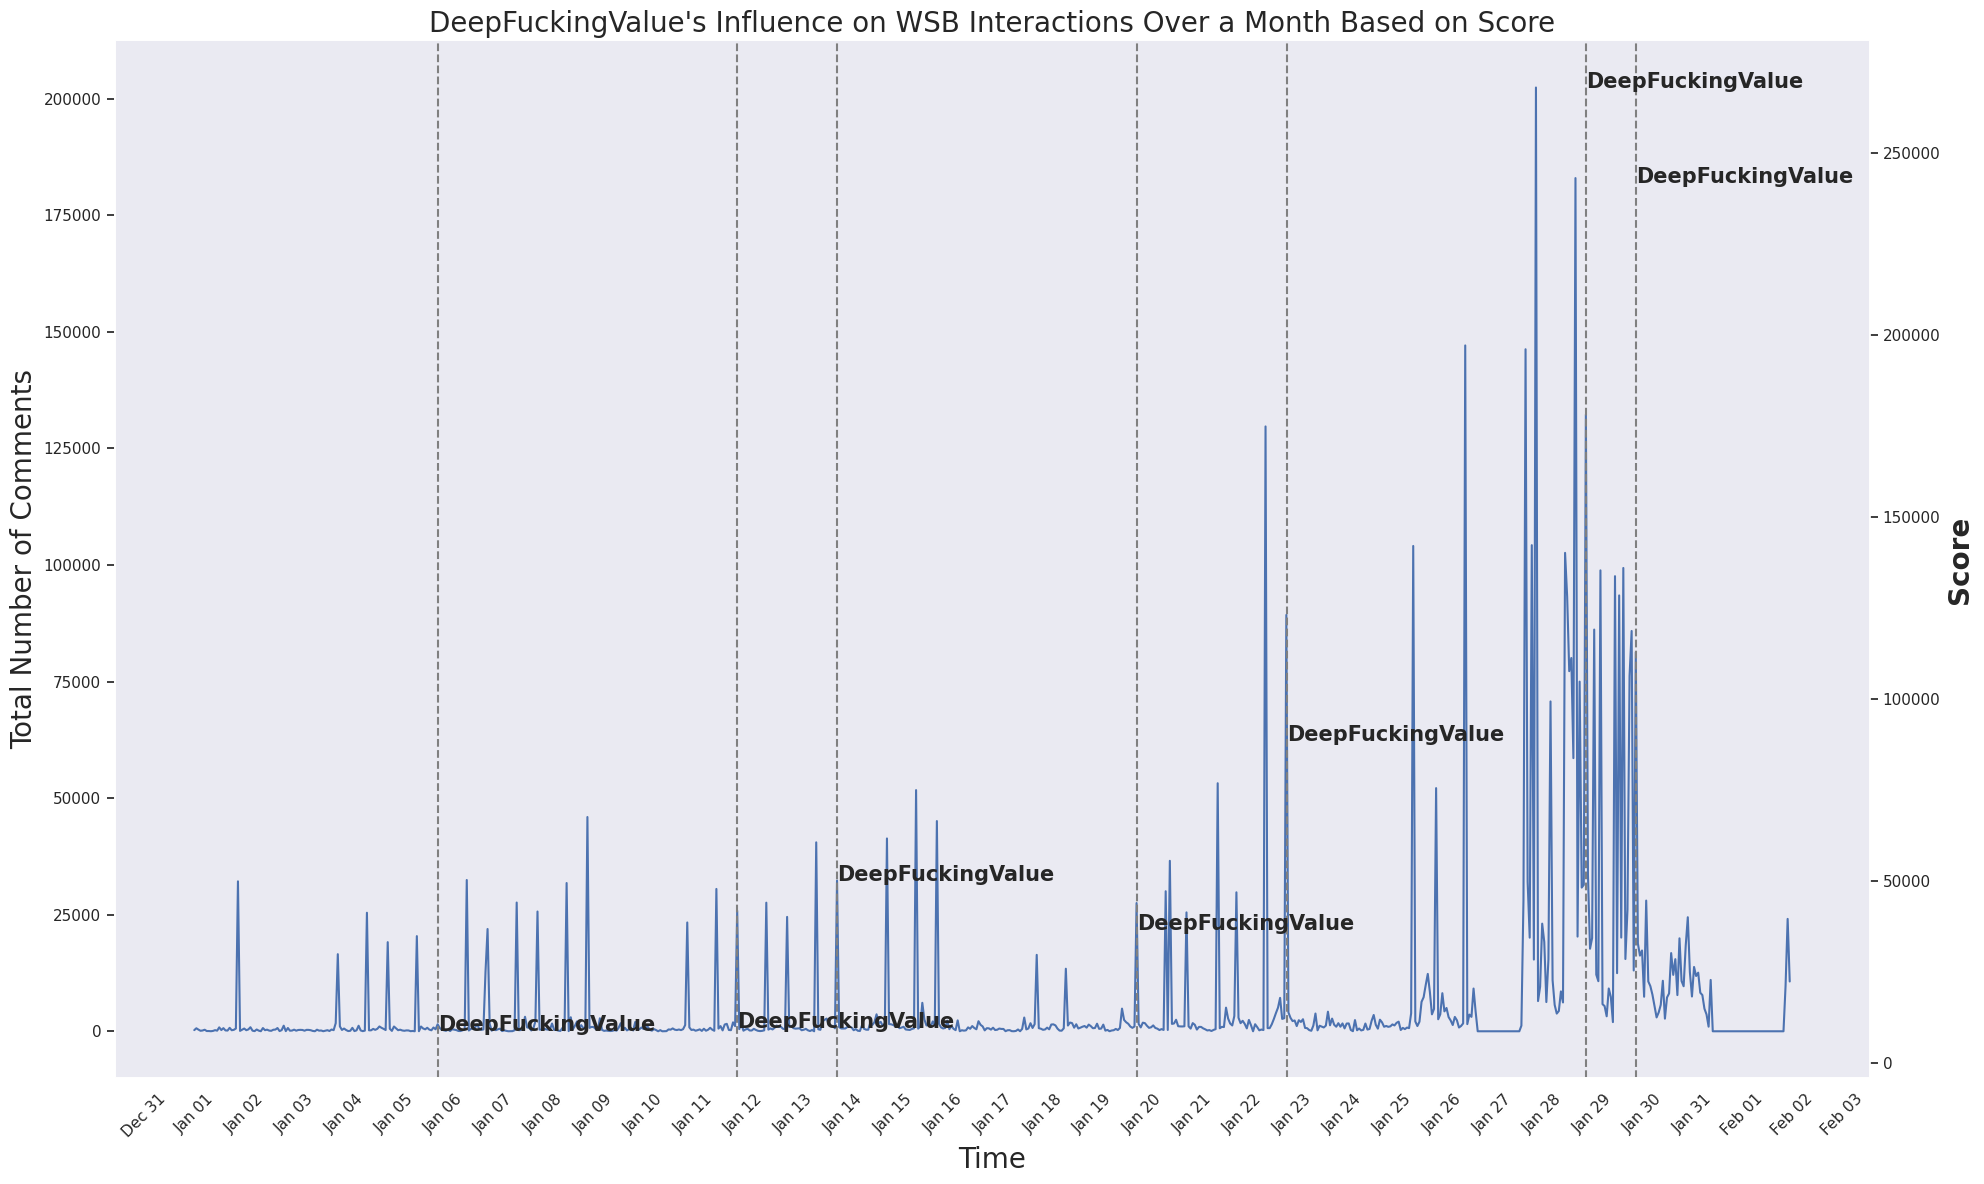

In [13]:
# @title DeepFuckingValue's Influence over a Month
#wsb_interaction = wsb_df[['created', 'num_comments']]

# Aggregate comments per day
wsb_comments_per_day = wsb_df.groupby(pd.Grouper(key='created', freq='H'))['num_comments'].sum().reset_index() # set frequency of groupings

### Plotting
fig, ax1 = plt.subplots(figsize=(20, 12))
sns.lineplot(x='created', y='num_comments', ax=ax1, data=wsb_comments_per_day)
ax1.set_title("DeepFuckingValue's Influence on WSB Interactions Over a Month Based on Score", fontsize=20)
ax1.set_xlabel('Time', fontsize=20)
ax1.set_ylabel('Total Number of Comments', fontsize=20)
plt.xticks(rotation=45)  # Rotating x-axis labels by 45 degrees

deepfuckingvalue_comments = wsb_df[wsb_df['author'] == 'DeepFuckingValue']

# Plotting scores on the right y-axis for the top posts
ax2 = ax1.twinx()
ax2.set_ylabel('Score', fontsize=20, weight='bold')

for index, row in deepfuckingvalue_comments.iterrows():
    ax1.axvline(row['created'], color='gray', linestyle='--', alpha=1)
    ax2.text(row['created'], row['score'], row['author'], ha='left', fontsize=15, weight='bold')
    ax2.scatter(row['created'], row['score'], color='red', s=0)  # Plotting score on right y-axis


# Format x-axis labels
ax1.xaxis.set_major_locator(mdates.DayLocator()) # Set major ticks at months
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d')) # Display month abbreviation and year

plt.tight_layout()
plt.savefig("DeepFuckingValue's Influence on WSB Interactions Over a Month.pdf")
plt.show()

# Calculate mean median, mode, … distribution of scores

In [ ]:
wsb_df['score'].value_counts()

1        254410
0         15379
2         11941
3          5944
4          3886
          ...  
13996         1
2598          1
1190          1
36204         1
29912         1
Name: score, Length: 2535, dtype: int64

In [ ]:
# Plotting the distribution of post scores

score_freq = wsb_df['score'].value_counts()

# Plotting using seaborn's displot
plt.figure(figsize=(10, 6))
sns.histplot(data=wsb_df, x="score", kde=True)
plt.title('Distribution of Post Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


# Language Processing Analysis


## NLTK and Language Processing

Here we need to:
1. Count the frequency of each word in the two dataframes
2. Remove the most frequent words that are not meaningful (*i.e.*, *the*, *and*, etc.)
  1. We need to proceed with caution because as we could only keep words of a certain length that appear at a certain frequency, but the length criteria might cut out some words that may be useful for our analysis like *we*, *our*, etc.
  2. Decide how to handle missing values.
    - Remove NaN values?
    - Impute missing values with a placeholder or a specific token indicating missingness, like *missing* &rarr; problem is that we might miss the word missing. Maybe replace with the string *NaN* itself?
    - Conditional processing? Do not take into account the rows where `NaN` values exist?
3. Lemmatizing the text data. Lemmatization is the process of reducing a word to its base or dictionary form. [See here](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/).
4. Make a distribution plot of the words frequency
5. Compare the two datasets in order to detect or not a more community building in one subreddit or the other.

In [ ]:
# @title Library Setup
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.text import Text
from itertools import chain
import string
import re
!pip install contractions
import contractions
from textblob import TextBlob
!pip install unidecode
from unidecode import unidecode
import numpy as np
import itertools


# Downloading resources
nltk.download(["punkt", "stopwords", "wordnet", "averaged_perceptron_tagger", "vader_lexicon"])

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

### Pre Processing Data Set

to do in order
1. Remove HTML Tags
2. Replace diacritics
3. Expand contractions
4. Remove Numbers
5. Typos correction
6. Composite Lemmatization process
  1. Remove special characters except period
  2. Lower case
  3. Lemmatize
  4. Remove periods and double spaces within each document
7. Stopwords removal



In [15]:
lemmatizer = WordNetLemmatizer()
pos_tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}

emoji_meanings = {
    "🚀": "moon ",
    "💎": "diamond hands ",
    "🙌": "diamond hands ",
    "🦍": "apes together strongs",
    "✋": "supportive",
    "🧻": "paper hands",
    "📰": "paper hands",
}


local_stopwords = set(stopwords.words('english'))
additional_stopwords = ["http", "u", "get", "like", "let", "nan", "would", "deleted", "removed"]
words_to_keep = ["i'm" " i ", "me", "my", "we", "our", "us", "Going to the moon", "Diamond", "Hands", "diamond hands", "apes", "together", "strongs", "supportive messages", "paper", "hands", "paper hands"]
local_stopwords.update(additional_stopwords)
for word in words_to_keep:
  if word in local_stopwords:
    local_stopwords.remove(word)

def lemmatize_pos_tagged_text(text, lemmatizer, pos_tag_dict):
    sentences = nltk.sent_tokenize(text)
    new_sentences = []

    for sentence in sentences:
        sentence = sentence.lower()
        new_sentence_words = []
        pos_tuples = nltk.pos_tag(nltk.word_tokenize(sentence))

        for word_idx, word in enumerate(nltk.word_tokenize(sentence)):
            nltk_word_pos = pos_tuples[word_idx][1]
            wordnet_word_pos = pos_tag_dict.get(nltk_word_pos[0].upper(), None)
            if wordnet_word_pos is not None:
                new_word = lemmatizer.lemmatize(word, wordnet_word_pos)
            else:
                new_word = lemmatizer.lemmatize(word)

            new_sentence_words.append(new_word)

        new_sentence = " ".join(new_sentence_words)
        new_sentences.append(new_sentence)

    return " ".join(new_sentences)

def preprocessing(text):

    # Emojy meaning replacement
    text = ''.join([emoji_meanings.get(word, word) for word in text])

    # Tokenization
    tokens = word_tokenize(text)

    # Lowercasing each word within the list
    tokens = [word.lower() for word in tokens]

    # Remove '[removed]', 'http', '[deleted]' patterns
    tokens = [re.sub(r"\[removed\]|https|\[deleted\]", '', word) for word in tokens]

    # Removing stopwords
    tokens = [word for word in tokens if word.isalpha() and word not in local_stopwords]

    # Replace diacritics
    tokens = [unidecode(word, errors="preserve") for word in tokens]

    # Expand contractions
    tokens = [" ".join([contractions.fix(expanded_word) for expanded_word in word.split()]) for word in tokens]

    # Remove numbers
    tokens = [re.sub(r'\d+', '', word) for word in tokens]

    # Remove punctuation except period
    tokens = [re.sub('[%s]' % re.escape(string.punctuation.replace('.', '')), '' , word) for word in tokens]

    # Remove double space
    tokens = [re.sub(' +', ' ', word) for word in tokens]

    # Lemmatization
    tokens = [lemmatize_pos_tagged_text(word, lemmatizer, pos_tag_dict) for word in tokens]

    return tokens

#### Combining Text Columns Data
Combining the columns for faster processing later

In [ ]:
wsb_processed = wsb_df.copy()
wsb_processed['title'] = wsb_processed['title'].fillna('')
wsb_processed['selftext'] = wsb_processed['selftext'].fillna('')

wsb_processed['tokens'] = wsb_processed['title'] + ' ' + wsb_processed['selftext']

In [16]:
opt_processed = opt_df.copy()
opt_processed['title'] = opt_processed['title'].fillna('')
opt_processed['selftext'] = opt_processed['selftext'].fillna('')

opt_processed['tokens'] = opt_processed['title'] + ' ' + opt_processed['selftext']

In [18]:
# @title Preprocessing Functions
#wsb_processed['tokens'] = wsb_processed['tokens'].apply(lambda s: preprocessing(s))
opt_processed['tokens'] = opt_processed['tokens'].apply(lambda s: preprocessing(s))

In [17]:
file_path = '/data/wsb_procssed.pkl'

# Save the list to disk using pickle
#with open(file_path, 'wb') as file:
#    pickle.dump(wsb_processed, file)

with open(file_path, 'rb') as file:
    wsb_processed = pickle.load(file)


## Topic Modeling

In [19]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np

In [20]:
from gensim import corpora, models

def topic_modeling(series, topics_num=10, passes=10, workers=4):
  dictionary = gensim.corpora.Dictionary(series)
  dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
  bow_corpus = [dictionary.doc2bow(doc) for doc in series]

  tfidf = models.TfidfModel(bow_corpus)
  corpus_tfidf = tfidf[bow_corpus]

  lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=topics_num, id2word=dictionary, passes=passes, workers=workers)

  return lda_model_tfidf

In [ ]:
#topics_opt = topic_modeling(opt_processed['tokens'], passes=30, workers=4)
# Save the dictionary to disk using pickle
#with open("topics_opt.pkl", 'wb') as file:
#    pickle.dump(topics_opt, file)


topics_wsb = topic_modeling(wsb_processed['tokens'], passes=20, workers=4)
with open("topics_wsb.pkl", 'wb') as file:
    pickle.dump(topics_wsb, file)

In [ ]:
#with open("topics_opt.pkl", 'rb') as file:
#    topics_opt = pickle.load(file)

with open("topics_wsb.pkl", 'rb') as file:
    topics_wsb = pickle.load(file)

In [ ]:
def visualize_topics(lda_model, num_topics=10, num_words=10, name="", date=""):
    for topic_id in range(num_topics):
        topic_words = lda_model.get_topic_terms(topic_id, topn=num_words)
        words = [lda_model.id2word[word_id] for word_id, _ in topic_words]
        importance = [prob for _, prob in topic_words]

        plt.figure(figsize=(8, 6))
        plt.barh(range(len(words)), importance, align='center', color='skyblue')
        plt.yticks(range(len(words)), words)
        plt.xlabel('Probability')
        plt.title(f'{name} Topic {topic_id} from {date}')
        plt.gca().invert_yaxis()  # Invert y-axis for better visualization

        plt.savefig(f'{name}_Topics_{topic_id}_From_{date}.pdf')
        plt.show()
        plt.close()
    return

#visualize_topics(topics_opt, name="opt")
#visualize_topics(topics_wsb, name="wsb")

In [ ]:
# @title Evolution of Topics Over Time
# Dissect the data set in multiple datasets that combine a two days frequency of comments

def topic_modeling_evolution(df, frequency="2D", topics_num=10, passes=10, workers=4, num_words=5, name=""):
  # Grouping the data frame based on a frequency of 2 days
  grouped = df.groupby(pd.Grouper(key='created', freq=frequency))

  # Applying topic_modeling function to each grouped data frame
  for group_interval, group_df in grouped:
    start_date = group_interval.strftime('%Y-%m-%d')  # Start date of the interval

    topics = topic_modeling(group_df['tokens'], topics_num, passes, workers)
    visualize_topics(topics, topics_num, num_words, name, start_date)

  return

In [ ]:
topic_modeling_evolution(opt_processed, frequency="15D", topics_num=5, passes=50, name="OPT")

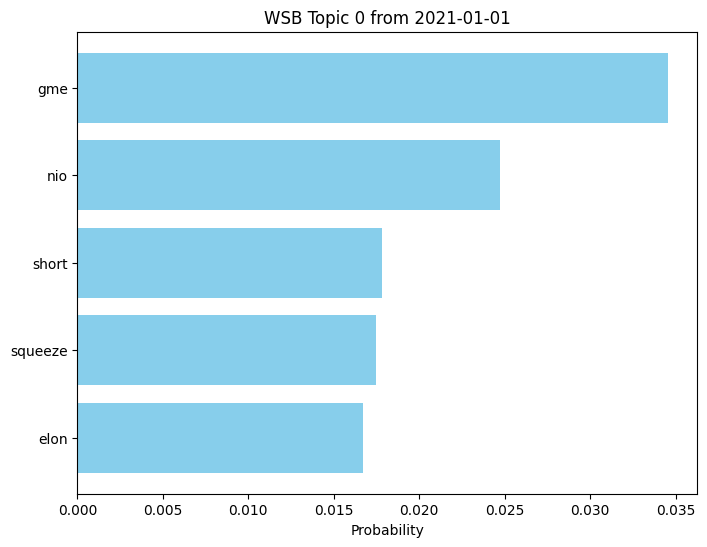

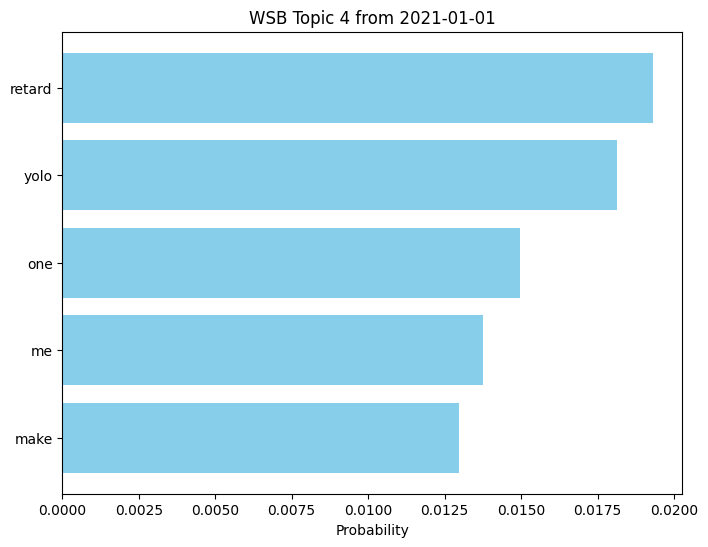

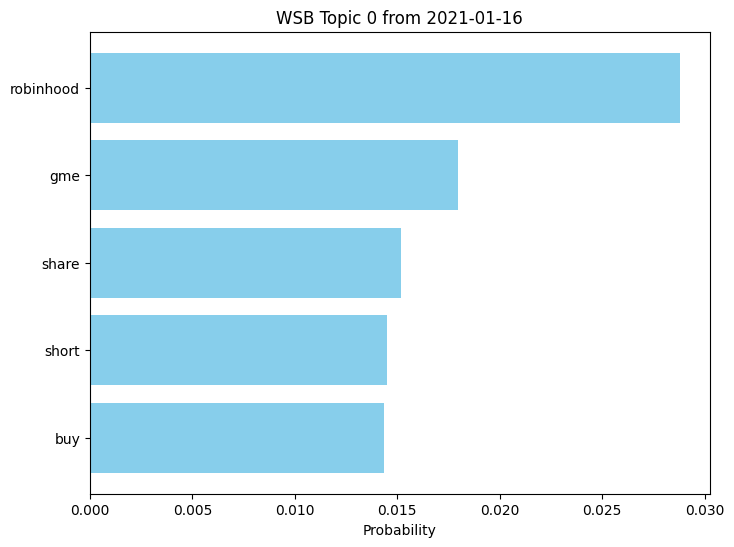

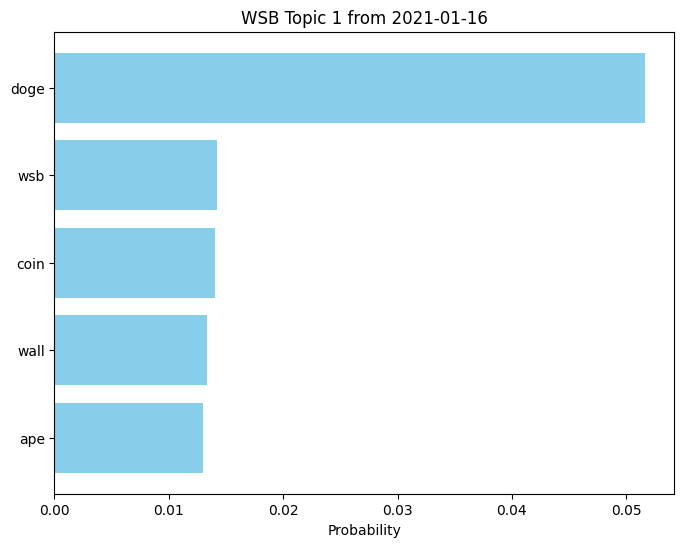

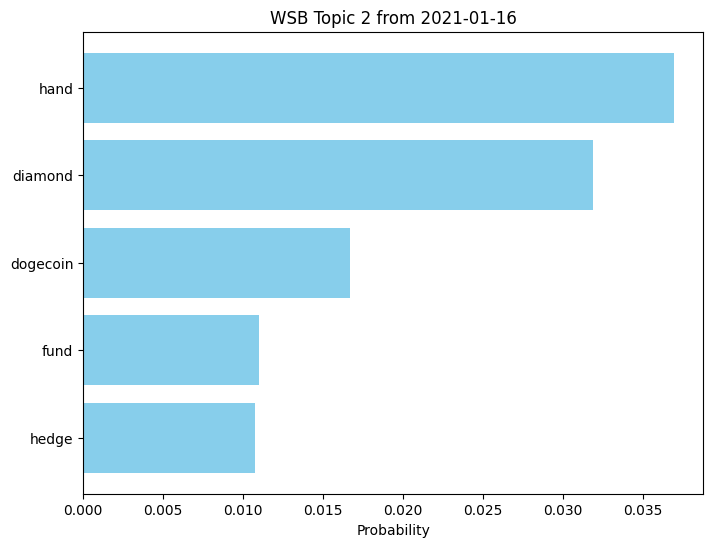

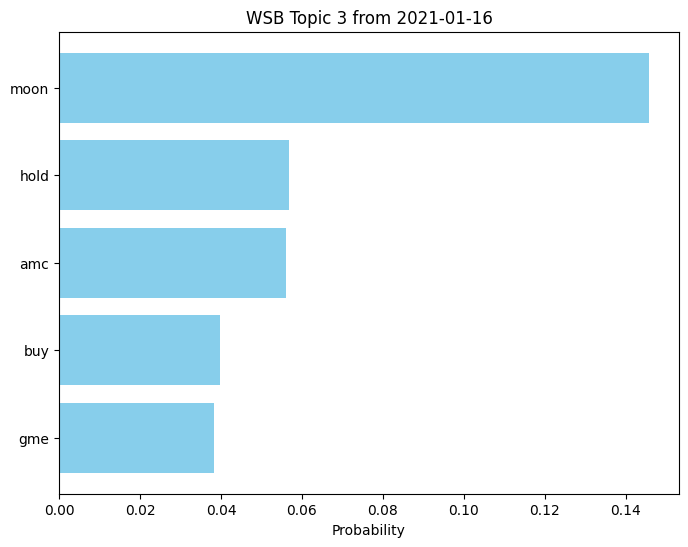

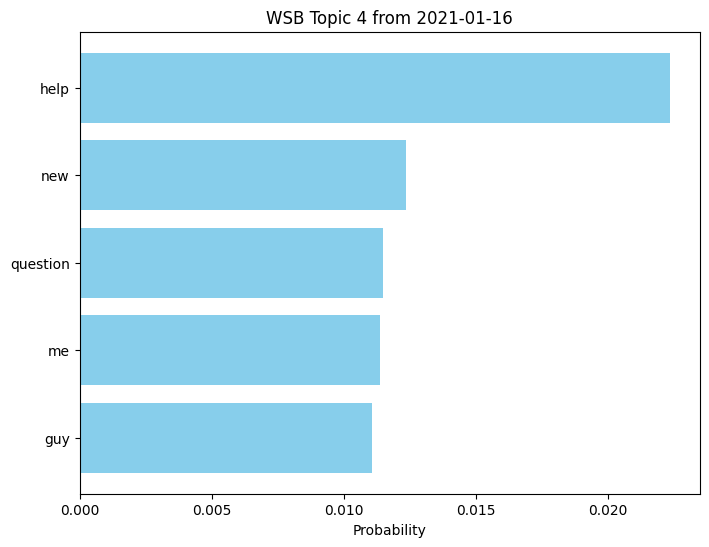

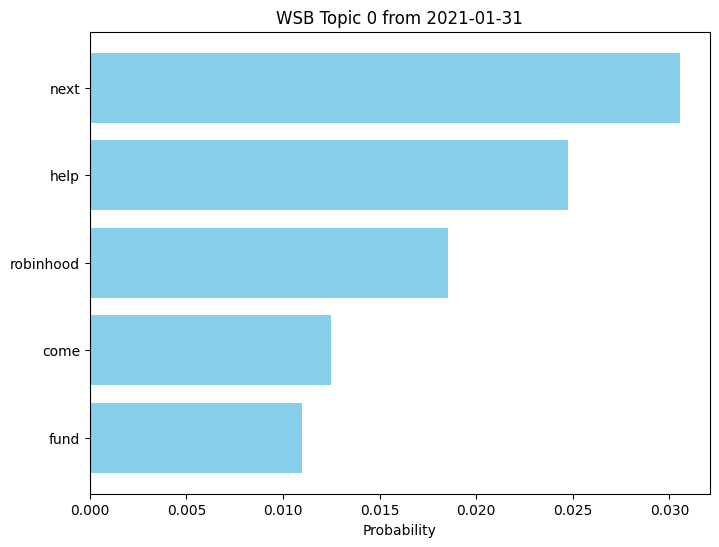

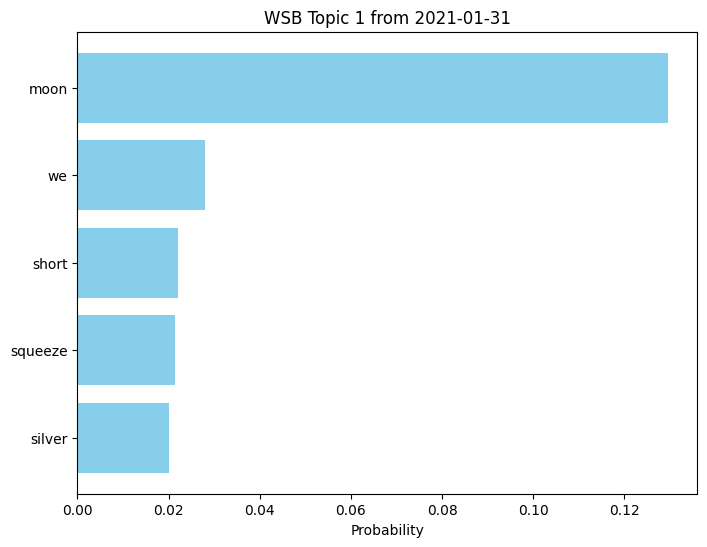

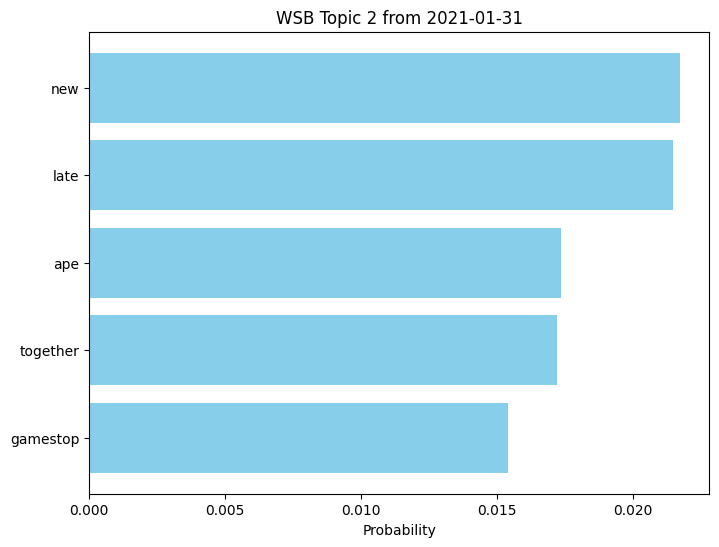

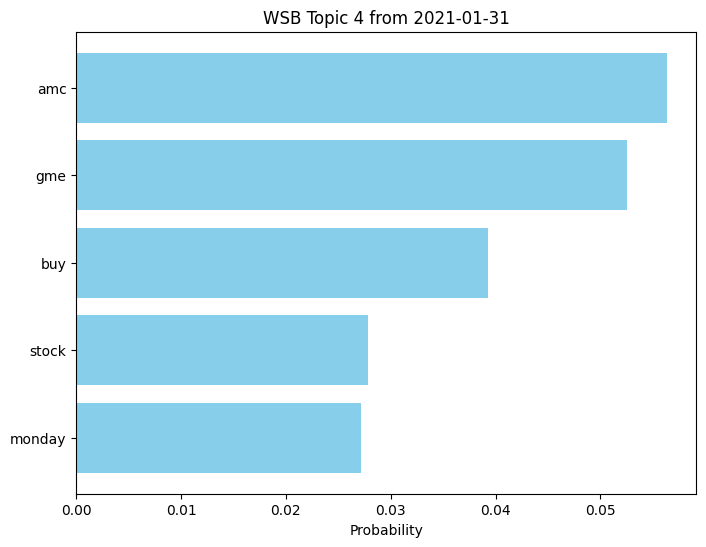

In [ ]:
topic_modeling_evolution(wsb_processed, frequency="15D", topics_num=5, passes=20, name="WSB")

## Frequency Distribution

In [22]:
# Frequency Distribution of Word Appearence

# Changing to text type
wsb_list = wsb_processed['tokens'].explode().tolist()
wsb_text = Text(wsb_list)

opt_list = opt_processed['tokens'].explode().tolist()
opt_text = Text(opt_list)

### Frequency Distribution of Themes

In [23]:
# @title Liste de mots férquents

#### WSB #####
wsb_word_freq = FreqDist(wsb_text)

# List of words you want to remove from the FreqDist
words_to_drop_wsb = ['u', 'go', 'one', 'today', 'http', 'new', 'time', 'still', 'wsb', 'know', 'want', 'got', 'even', 'way', 'also',]

# Remove specified words from the FreqDist
for word in words_to_drop_wsb:
    if word in wsb_word_freq:
        del wsb_word_freq[word]

# Now you can use most_common() on word_freq_150_wsb
wsb_150_top_words = wsb_word_freq.most_common(150)

#### OPT ####
opt_word_freq = FreqDist(opt_text)

# List of words you want to remove from the FreqDist
words_to_drop_opt = ['u', 'go', 'one', 'today', 'http', 'new', 'time', 'still', 'wsb', 'know', 'want', 'got', 'even', 'way', 'also',]

# Remove specified words from the FreqDist
for word in words_to_drop_opt:
    if word in opt_word_freq:
        del opt_word_freq[word]

# Now you can use most_common() on word_freq_150_wsb
opt_150_top_words = opt_word_freq.most_common(150)


In [24]:
wsb_words_dict = {word: freq for word, freq in wsb_word_freq.items()}
opt_words_dict = {word: freq for word, freq in opt_word_freq.items()}

In [45]:
# Making up themes based on selected key words
# For WSB
wsb_jargon = ['moon', 'retard', 'diamond', 'tendies', 'yolo', 'hand', 'rocket', 'line', 'meme', 'gon', 'hold', 'ape', 'monkey']
wsb_individual = ['my', 'me', 'guy', 'boy', 'anyone', 'someone', 'i am']
wsb_collective = ['we', 'people', 'our', 'everyone', 'together', 'many']
wsb_finance = ['gme', 'amc', 'stock', 'robinhood', 'share', 'market', 'money', 'fund', 'gamestop', 'doge', 'price', 'company', 'call', 'dogecoin', 'account', 'position', 'option', 'dip', 'put', 'broker', 'wall', 'melvin', 'long', 'street', 'nokia', 'investor', 'part', 'game', 'financial', 'webull', 'manipulation', 'sndl', 'interest', 'million', 'free', 'nok', 'bb','nakd', 'rh', 'app', 'platform']
wsb_action = ['buy', 'hold', 'short', 'going', 'sell', 'trading', 'make', 'buying', 'keep', 'need', 'help', 'squeeze', 'hedge', 'bought', 'take', 'think', 'trade', 'see', 'stop', 'would', 'selling', 'let us', 'could', 'post', 'look', 'trying', 'made', 'say', 'open', 'use', 'gain', 'getting', 'give', 'thought', 'come', 'move', 'invest', 'do not', 'start', 'play', 'work', 'hit', 'win', 'sold', 'holding', 'advice', 'question']
wsb_emotion = ['fuck', 'shit', 'love', 'best', 'never', 'fucking', 'good', 'right', 'big', 'much', 'please', 'strong', 'well', 'another', 'really', 'limit', 'high', 'little', 'power', 'every', 'something', 'lot']
wsb_timing = ['day', 'week', 'tomorrow', 'year', 'first', 'order', 'last', 'back', 'next', 'late', 'start', 'monday', 'since']

wsb_theme_lists = {'wsb_jargon': wsb_jargon, 'individual': wsb_individual, 'collective': wsb_collective, 'finance': wsb_finance, 'action': wsb_action, 'emotion': wsb_emotion, 'timing': wsb_timing}
wsb_150_top_words_dict = {word: freq for word, freq in wsb_150_top_words}

# For OPT
opt_finance = ['option', 'call', 'stock', 'put', 'gme', 'share', 'short', 'price', 'spread', 'trading', 'covered', 'market', 'long', 'company', 'contract', 'itm', 'trade', 'earnings', 'strategy', 'position', 'money', 'squeeze', 'profit', 'loss', 'gain', 'term', 'credit', 'revenue', 'tsla', 'otm', 'value', 'tax', 'premium', 'risk', 'trader', 'cash', 'account', 'robinhood', 'lockheed', 'broker', 'interest', 'amp', 'delta', 'tesla', 'business', 'gamestop', 'amc', 'bb', 'investor', 'margin', 'bull', 'data', 'platform']
opt_action = ['buy', 'hold', 'short', 'going', 'sell', 'trading', 'make', 'buying', 'keep', 'need', 'help', 'squeeze', 'hedge', 'bought', 'take', 'think', 'trade', 'see', 'stop', 'would', 'selling', 'let us', 'could', 'post', 'look', 'trying', 'made', 'say', 'open', 'use', 'gain', 'getting', 'give', 'thought', 'come', 'move', 'invest', 'do not', 'start', 'play', 'work', 'hit', 'win', 'sold', 'holding', 'advice', 'question']
opt_collective = ['we', 'people', 'our', 'everyone', 'together', 'many']
opt_individual = ['my', 'me', 'anyone', 'guy', 'user', 'someone', 'another']
opt_emotion = ['fuck', 'shit', 'love', 'best', 'never', 'fucking', 'good', 'right', 'big', 'much', 'please', 'strong', 'well', 'another', 'really', 'limit', 'high', 'little', 'power', 'every', 'something', 'lot']
opt_timing = ['day', 'week', 'tomorrow', 'year', 'first', 'order', 'last', 'back', 'next', 'late', 'start', 'monday', 'since', 'expiration', 'weekly', 'yesterday', 'last', 'already', 'jan', 'tomorrow', 'since', 'end', 'order', 'back']

opt_theme_lists = {'individual': opt_individual, 'collective': opt_collective, 'finance': opt_finance, 'action': opt_action, 'emotion': opt_emotion, 'timing': opt_timing}
opt_150_top_words_dict = {word: freq for word, freq in opt_150_top_words}



In [26]:
def themes_frequency(themes_list, top_words_dict, absolute):
  # Initialize sum of frequencies
  themes_frequency = {}

  # Calculate total frequency of all words
  total_frequency_all_words = sum(top_words_dict.values())

  # Calculate percentage frequency for each list
  for theme_name, word_list in themes_list.items():
      theme_frequency = sum(top_words_dict[word] for word in word_list if word in top_words_dict)
      if absolute:
        themes_frequency[theme_name] = theme_frequency
      else:
        percentage_theme_frequency = (theme_frequency / total_frequency_all_words) * 100
        themes_frequency[theme_name] = percentage_theme_frequency
  return themes_frequency


# Function to create the new top 150 words dictionary to be passed to the themes frequency function

def top_words_per_interval(df, frequency, words_to_drop, most_common):

  top_words_per_interval = {}

  grouped = df.groupby(pd.Grouper(key='created', freq=frequency))

  for group_date, group_df in grouped:
    # Changing to text type
    df_list = group_df['tokens'].explode().tolist()
    df_text = Text(df_list)
    word_freq = FreqDist(df_text)

    # Remove specified words from the FreqDist
    for word in words_to_drop:
        if word in word_freq:
            del word_freq[word]

    # Now you can use most_common() on word_freq_150_wsb
    top_words = word_freq.most_common(most_common)
    top_words_per_interval[group_date] = [word for word in top_words]

  return top_words_per_interval

def convert_tuples_to_dict(dictionary):
    converted_dict = {}
    for interval, word_freq_list in dictionary.items():
        converted_dict[interval] = {word: freq for word, freq in word_freq_list}
    return converted_dict

def themes_frequency_evolution(df, themes_list, top_words_dict, frequency, words_to_drop, most_common, absolute=True):
    top_words_interval = top_words_per_interval(df, frequency, words_to_drop, most_common)
    top_words_interval_dict = convert_tuples_to_dict(top_words_interval)

    themes_frequency_results = {}

    for name, top_words_dict in top_words_interval_dict.items():
      themes_freq = themes_frequency(themes_list, top_words_dict, absolute)
      themes_frequency_results[name] = themes_freq

    return themes_frequency_results

def plot_themes_evolution(df, themes_list, top_words_dict, frequency='2D', words_to_drop=words_to_drop_wsb, most_common=150, name='', absolute=True):

    data = themes_frequency_evolution(df, themes_list, top_words_dict, frequency, words_to_drop, most_common, absolute)

    # Extract keys (themes)
    themes = list(data[next(iter(data))].keys())

    # Plotting
    plt.figure(figsize=(10, 6))

    for theme in themes:
        x = list(data.keys())
        y = [data[timestamp][theme] for timestamp in x]
        plt.plot(x, y, label=theme)

    plt.xlabel('Time')
    if absolute:
      plt.ylabel('Frequency')
      plt.title(f'Evolution of Themes Usage over Time for {name} (in Absolute Terms)')
    else:
      plt.ylabel('Percentage Frequency')
      plt.title(f'Evolution of Themes Representation over Time for {name} (in Percentage Terms)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show plot
    if absolute:
      plt.savefig(f'Evolution of Themes Usage over Time for {name}.png')
    else:
      plt.savefig(f'Evolution of Themes Representation over Time for {name}.png')

    plt.show()

#### Plotting Precentage Frequency of Themes

In [66]:
def plot_frequency_themes(themes_list, top_words_dict, name="", absolute=False):

  results = themes_frequency(themes_list, top_words_dict, absolute)

  theme_names = list(results.keys())
  percentages = list(results.values())

  # Plotting the bar chart
  plt.figure(figsize=(10, 6))
  plt.bar(theme_names, percentages, color='orange', linewidth=0)
  plt.xlabel('Themes')
  plt.ylabel('Percentage Frequency')
  plt.title(f'Percentage Frequency of Themes for {name}')
  #plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  plt.grid(True)  # Enable grid in Matplotlib plot
  plt.tight_layout()

  plt.ylim(0, 25)  # Sets the y-axis limit to 0% to 20%

  # Show the plot
  plt.savefig(f'Precentage Frequency of Themes for {name}.png')
  plt.show()

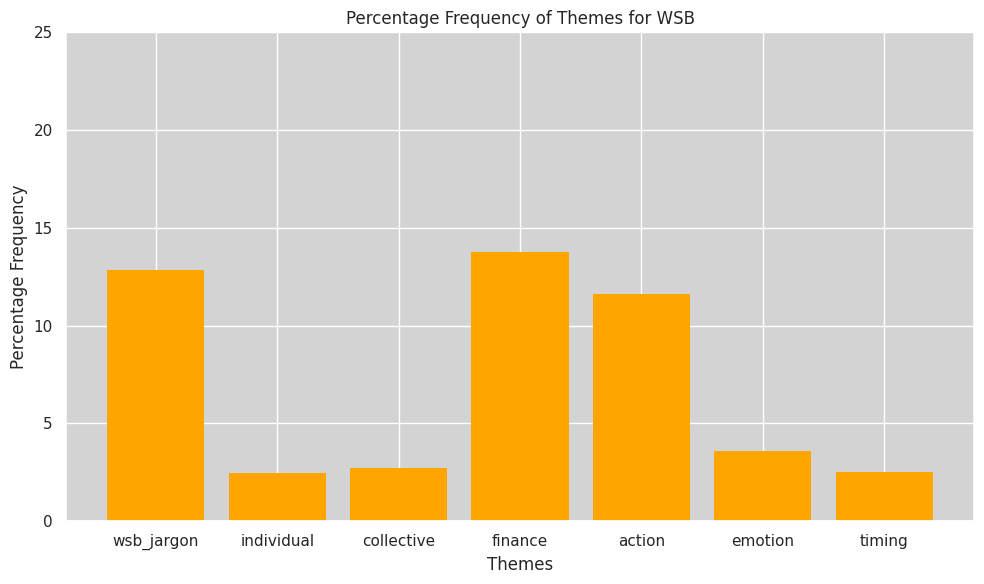

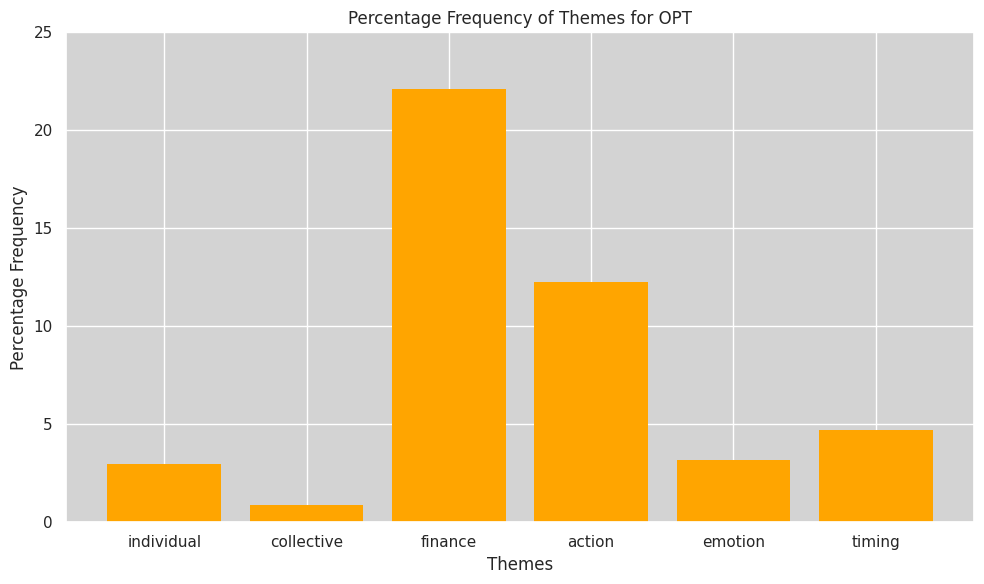

In [71]:
plot_frequency_themes(wsb_theme_lists, wsb_words_dict, "WSB")
plot_frequency_themes(opt_theme_lists, opt_words_dict, "OPT")

#### Evolution of Themes Over Time

In [61]:
plot_themes_evolution(opt_processed, opt_theme_lists, opt_words_dict, name="OPT")
plot_themes_evolution(wsb_processed, wsb_theme_lists, wsb_words_dict, name="WSB")
plot_themes_evolution(opt_processed, opt_theme_lists, opt_words_dict, name="OPT", absolute=False)
plot_themes_evolution(wsb_processed, wsb_theme_lists, wsb_words_dict, name="WSB", absolute=False)

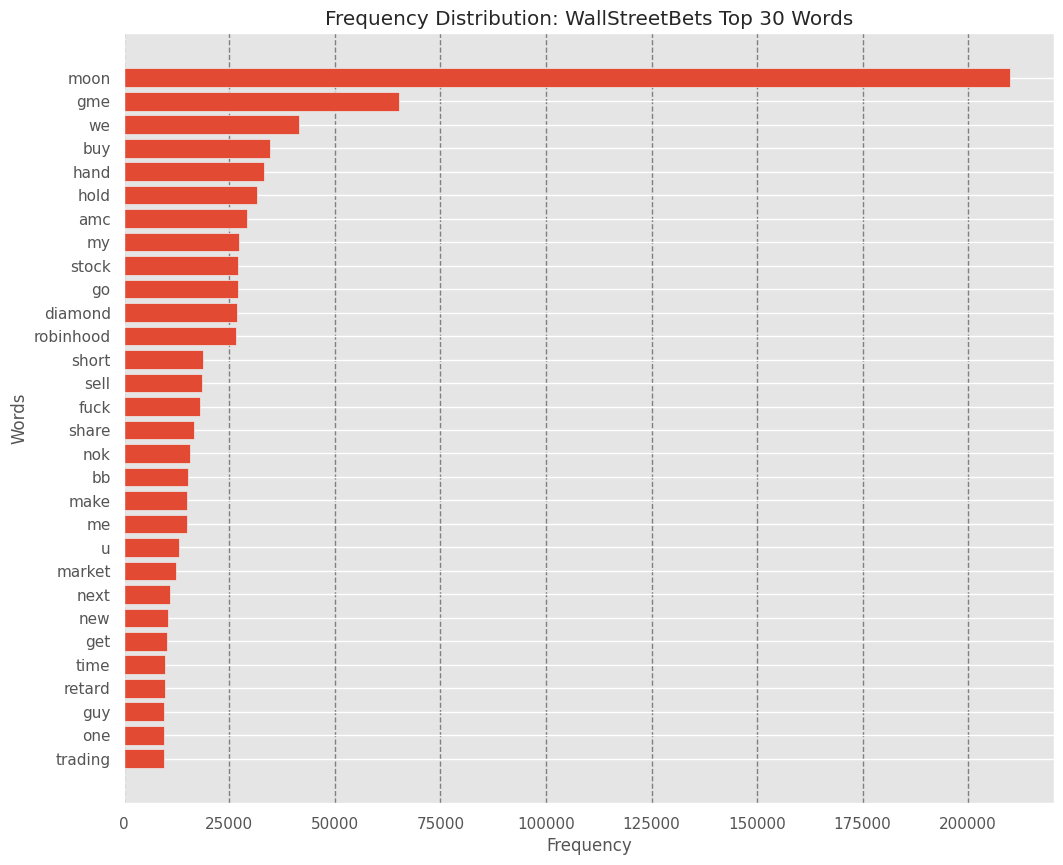

In [ ]:
# @title Ploting the Graphs

# Extract words and frequencies for plotting
wsb_word_freq = FreqDist(wsb_text)
wsb_top_words = wsb_word_freq.most_common(30)

opt_word_freq = FreqDist(opt_text)
opt_top_words = opt_word_freq.most_common(30)

wsb_words, wsb_frequencies = zip(*wsb_top_words)
opt_words, opt_frequencies = zip(*opt_top_words)

# Create a horizontal bar chart for OPT
plt.style.use('ggplot')
plt.figure(figsize=(12, 10))  # Adjust figure size to indirectly affect spacing
plt.barh(wsb_words, wsb_frequencies)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Frequency Distribution: WallStreetBets Top 30 Words')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(axis='x', linestyle='--', alpha=1, color='grey')  # Add gridlines
plt.savefig('Frequency Distribution: WallStreetBets Top 30 Words.png')
plt.show()

# Create a horizontal bar chart for OPT
plt.style.use('ggplot')
plt.figure(figsize=(12, 10))  # Adjust figure size to indirectly affect spacing
plt.barh(opt_words, opt_frequencies)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Frequency Distribution: Options Top 30 Words')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(axis='x', linestyle='--', alpha=1, color='grey')  # Add gridlines
plt.savefig('Frequency Distribution: Options Top 30 Words.png')
plt.show()